Transfer Learning con TensorFlow Hub --- 0:00 min
===

* Última modificación: Marzo 1, 2022 | YouTube

Importación de librerías
---

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

Imagenet
---

**Descarga**

In [2]:
#
# Descarga
#
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [3]:
import tensorflow_hub as hub

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential(
    [
        hub.KerasLayer(
            classifier_model,
            input_shape=IMAGE_SHAPE + (3,),
        )
    ]
)

**Corrida sobre una sola imágen**

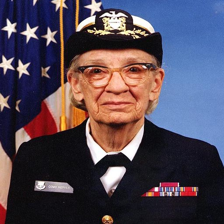

In [4]:
import PIL.Image

grace_hopper = tf.keras.utils.get_file(
    "image.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg",
)
grace_hopper = PIL.Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [5]:
import numpy as np

grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

In [6]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [7]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

**Decodificación de las predicciones**

In [8]:
labels_path = tf.keras.utils.get_file(
    "ImageNetLabels.txt",
    "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt",
)
imagenet_labels = np.array(open(labels_path).read().splitlines())

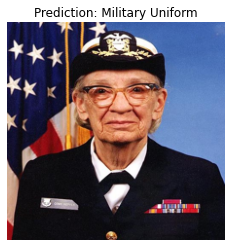

In [9]:
import matplotlib.pyplot as plt

plt.imshow(grace_hopper)
plt.axis("off")
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

Transfer learning básico
---

**Preparación del dataset**

In [10]:
#
# Descarga del dataset
#
data_root = tf.keras.utils.get_file(
    "flower_photos",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    untar=True,
    cache_subdir="/tmp/flower_photos",
)

In [11]:
#
# Conjuntos de entrenamiento y validación
#

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
#
# Clases
#
class_names = np.array(train_ds.class_names)
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [13]:
#
# Escalamiento
#
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:
#
# Configuración para el desempeño
#
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


**Ejecución del clasificador sobre un conjunto de imágenes**

In [16]:
result_batch = classifier.predict(train_ds)

In [17]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

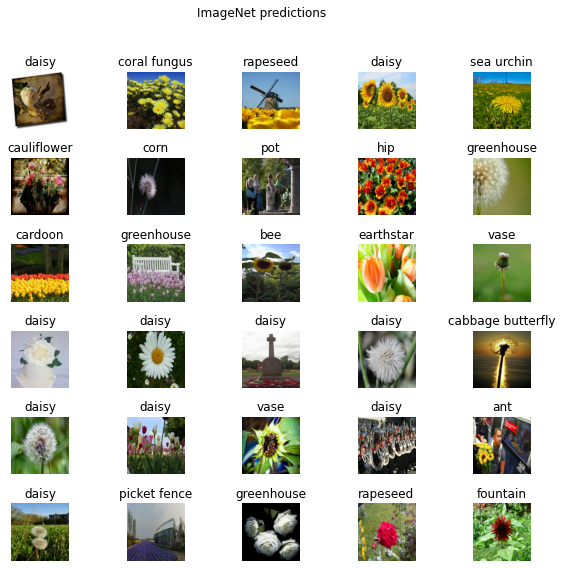

In [18]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis("off")
_ = plt.suptitle("ImageNet predictions")

**Descarga del modelo sin cabecera**

In [19]:
feature_extractor_model = mobilenet_v2

In [20]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False,
)

In [21]:
feature_batch = feature_extractor_layer(image_batch)
feature_batch.shape

TensorShape([32, 1001])

**Adición de una cabeza de clasificación**

In [22]:
num_classes = len(class_names)

model = tf.keras.Sequential(
    [
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 dense (Dense)               (None, 5)                 5010      
                                                                 
Total params: 3,545,275
Trainable params: 5,010
Non-trainable params: 3,540,265
_________________________________________________________________


In [23]:
predictions = model(image_batch)

In [24]:
predictions.shape

TensorShape([32, 5])

**Entrenamiento del modelo**

In [25]:
import datetime

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)

log_dir = "/tmp/hub/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
)

In [26]:
NUM_EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks=tensorboard_callback,
)

Epoch 1/10
92/92 [==============================] - 42s 424ms/step - loss: 0.7505 - acc: 0.7275 - val_loss: 0.4150 - val_acc: 0.8542
Epoch 2/10
92/92 [==============================] - 40s 435ms/step - loss: 0.3584 - acc: 0.8709 - val_loss: 0.3628 - val_acc: 0.8787
Epoch 3/10
92/92 [==============================] - 38s 418ms/step - loss: 0.2828 - acc: 0.9016 - val_loss: 0.3516 - val_acc: 0.8815
Epoch 4/10
92/92 [==============================] - 38s 414ms/step - loss: 0.2394 - acc: 0.9189 - val_loss: 0.3509 - val_acc: 0.8828
Epoch 5/10
92/92 [==============================] - 39s 430ms/step - loss: 0.2100 - acc: 0.9298 - val_loss: 0.3539 - val_acc: 0.8828
Epoch 6/10
92/92 [==============================] - 38s 414ms/step - loss: 0.1880 - acc: 0.9401 - val_loss: 0.3583 - val_acc: 0.8883
Epoch 7/10
92/92 [==============================] - 41s 445ms/step - loss: 0.1705 - acc: 0.9482 - val_loss: 0.3632 - val_acc: 0.8856
Epoch 8/10
92/92 [==============================] - 43s 467ms/step - 

In [27]:
%load_ext tensorboard
%tensorboard  --ip 0.0.0.0 --logdir /tmp/hub/logs/fit/

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [-

![assets/tensorboard_transfer_learning_with_hub.png](assets/tensorboard_transfer_learning_with_hub.png)

**Verificación de las predicciones**

In [28]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


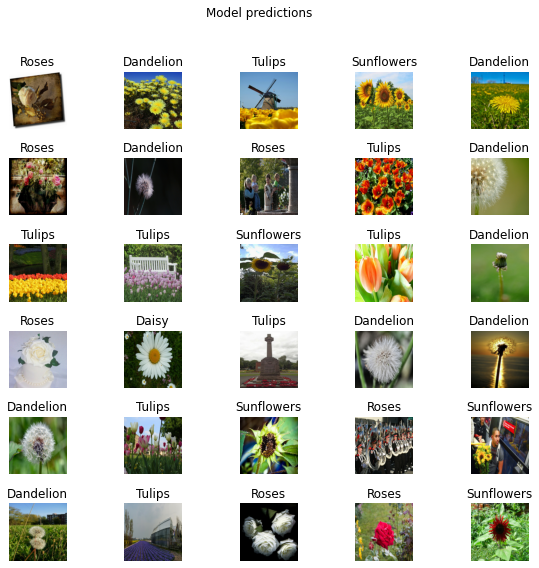

In [29]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis("off")
_ = plt.suptitle("Model predictions")

Exportación y carga del modelo
---

In [30]:
import time

t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1646242107/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1646242107/assets


'/tmp/saved_models/1646242107'

In [31]:
reloaded = tf.keras.models.load_model(export_path)

In [32]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [33]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [34]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
reloaded_predicted_label_batch

array(['roses', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'roses',
       'dandelion', 'roses', 'tulips', 'dandelion', 'tulips', 'tulips',
       'sunflowers', 'tulips', 'dandelion', 'roses', 'daisy', 'tulips',
       'dandelion', 'dandelion', 'dandelion', 'tulips', 'sunflowers',
       'roses', 'sunflowers', 'dandelion', 'tulips', 'roses', 'roses',
       'sunflowers', 'tulips', 'sunflowers'], dtype='<U10')

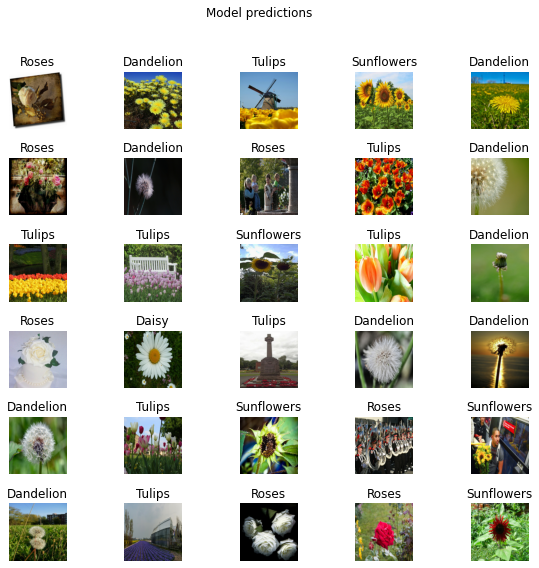

In [35]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(reloaded_predicted_label_batch[n].title())
    plt.axis("off")
    
_ = plt.suptitle("Model predictions")